In [159]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras as keras
from sklearn.preprocessing import label_binarize
from tf_keras import layers, models, optimizers
import tf_keras as legacy_keras
from tf_keras.optimizers import Adam
from tf_keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

os.environ["TF_USE_LEGACY_KERAS"] = "1"

# Loading the Dataset


In [7]:
file_path = '/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv'

names = ['class']

names.extend([i for i in range(1, 785)])

df = pd.read_csv(file_path, header=None, names=names)

df.shape

(372451, 785)

In [8]:
df.head()

,class,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
y_full = df['class']
x_full = df.drop('class', axis=1).values.reshape(-1, 28, 28, 1)

In [10]:
print('X shape: ' + str(x_full.shape))
print('Y shape: ' + str(y_full.shape))

X shape: (372451, 28, 28, 1)
Y shape: (372451,)


In [11]:
print([x_full.min(), x_full.max()])

[0, 255]


# Splitting Dataset


In [12]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in splitter.split(x_full, y_full):
    x_train_full, y_train_full = x_full[train_idx], y_full.iloc[train_idx].values
    x_test, y_test = x_full[test_idx], y_full.iloc[test_idx].values

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full,
    y_train_full,
    test_size=0.1,
    stratify=y_train_full,
    random_state=42
)

'''
X_train, Y_train => 72% of the dataset
X_valid, Y_valid => 8% of the dataset
X_test, Y_test => 20% of the dataset

'''

'\nX_train, Y_train => 72% of the dataset\nX_valid, Y_valid => 8% of the dataset\nX_test, Y_test => 20% of the dataset\n\n'

# Data Preprocessing & Augmentation


In [96]:
batch_size = 32
steps_train = math.ceil(len(x_train) / batch_size)
steps_test = math.ceil(len(x_test)/ batch_size)
steps_valid = math.ceil(len(x_valid)/ batch_size)

In [97]:
train_datagen = ImageDataGenerator(
    rotation_range=20, # Randomized Rotation between -20 & 20
    width_shift_range=0.15, # Randomized Shifting Over X-axis between -.15 & .15
    height_shift_range=0.15, # Randomized Shifting Over Y-axis between -.15 & .15
    zoom_range=0.20, # Randomized Zoom between -.20 & .20
    rescale=1./255, # Normalize Every Pixel in the image to be between [0, 1]
)

In [98]:
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

In [99]:
train_loader = train_datagen.flow(
    x_train, y_train,
    batch_size=batch_size,
    shuffle=True
)

In [100]:
valid_loader = valid_datagen.flow(
    x_valid, y_valid,
    batch_size=batch_size,
    shuffle=False
)

In [101]:
test_loader = test_datagen.flow(
    x_test, y_test,
    batch_size=batch_size,
    shuffle=False
)

# Building the pretrained Inception V1 (GoogLeNet)


In [102]:
def build_inception_v1_model(num_classes=26):
    
    model = models.Sequential(name="InceptionV1_GoogLeNet_Transfer")

    # 1. Accept small images (28x28)
    model.add(layers.InputLayer(input_shape=(28, 28, 1)))

    # 2. Resize & Color (On GPU)
    model.add(layers.Resizing(224, 224, interpolation='bilinear'))
    model.add(layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)))
    
    inception_v1_url = "https://tfhub.dev/google/imagenet/inception_v1/feature_vector/5"
    
    base_model = hub.KerasLayer(
        inception_v1_url,
        trainable=False, # Freeze the weights
        input_shape=(224, 224, 3)
    )
    model.add(base_model)

    # --- 6. CLASSIFICATION HEAD ---
    # TF Hub feature vectors usually output a flat vector, so we don't need Flatten/GlobalPool
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [113]:
model = build_inception_v1_model(num_classes=26) 


model.summary()

Model: "InceptionV1_GoogLeNet_Transfer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (None, 224, 224, 1)       0         
                                                                 
 lambda_3 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 keras_layer_3 (KerasLayer)  (None, 1024)              5607184   
                                                                 
 dense_9 (Dense)             (None, 512)               524800    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               65664     
                                                                 
 dropout_7 (Dropout)         (None, 

# Train The Top Layers Of The Model (Classification layer)


In [114]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [115]:
checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/inception_v1_A_Z_classification', # Use .h5 for legacy keras
    monitor='val_accuracy',          # Watch Validation Accuracy
    save_best_only=True,             # Overwrite only if accuracy improves
    save_weights_only=False,         # Save the whole model (architecture + weights)
    mode='max',                      # We want MAX accuracy
    verbose=1
)

In [116]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history_stage_1 = model.fit(
    train_loader,
    validation_data=valid_loader,
    epochs=50,
    callbacks=[early_stop, checkpoint],
    steps_per_epoch=steps_train,
    validation_steps=steps_valid
)

Epoch 1/50
8379/8381 [============================>.] - ETA: 0s - loss: 0.6740 - accuracy: 0.7977
Epoch 1: val_accuracy improved from -inf to 0.90626, saving model to /kaggle/working/inception_v1_A_Z_classification
INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


8381/8381 [==============================] - 232s 27ms/step - loss: 0.6739 - accuracy: 0.7977 - val_loss: 0.3045 - val_accuracy: 0.9063
Epoch 2/50
8380/8381 [============================>.] - ETA: 0s - loss: 0.4560 - accuracy: 0.8644
Epoch 2: val_accuracy improved from 0.90626 to 0.92858, saving model to /kaggle/working/inception_v1_A_Z_classification
INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


8381/8381 [==============================] - 228s 27ms/step - loss: 0.4560 - accuracy: 0.8644 - val_loss: 0.2454 - val_accuracy: 0.9286
Epoch 3/50
8380/8381 [============================>.] - ETA: 0s - loss: 0.4086 - accuracy: 0.8804
Epoch 3: val_accuracy improved from 0.92858 to 0.93362, saving model to /kaggle/working/inception_v1_A_Z_classification
INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


8381/8381 [==============================] - 227s 27ms/step - loss: 0.4086 - accuracy: 0.8804 - val_loss: 0.2189 - val_accuracy: 0.9336
Epoch 4/50
8381/8381 [==============================] - ETA: 0s - loss: 0.3851 - accuracy: 0.8872
Epoch 4: val_accuracy improved from 0.93362 to 0.93650, saving model to /kaggle/working/inception_v1_A_Z_classification
INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


8381/8381 [==============================] - 227s 27ms/step - loss: 0.3851 - accuracy: 0.8872 - val_loss: 0.2130 - val_accuracy: 0.9365
Epoch 5/50
8379/8381 [============================>.] - ETA: 0s - loss: 0.3672 - accuracy: 0.8935
Epoch 5: val_accuracy improved from 0.93650 to 0.93929, saving model to /kaggle/working/inception_v1_A_Z_classification
INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


8381/8381 [==============================] - 228s 27ms/step - loss: 0.3672 - accuracy: 0.8935 - val_loss: 0.2040 - val_accuracy: 0.9393
Epoch 6/50
8379/8381 [============================>.] - ETA: 0s - loss: 0.3564 - accuracy: 0.8967
Epoch 6: val_accuracy improved from 0.93929 to 0.94083, saving model to /kaggle/working/inception_v1_A_Z_classification
INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


8381/8381 [==============================] - 226s 27ms/step - loss: 0.3564 - accuracy: 0.8966 - val_loss: 0.2023 - val_accuracy: 0.9408
Epoch 7/50
8380/8381 [============================>.] - ETA: 0s - loss: 0.3446 - accuracy: 0.9008
Epoch 7: val_accuracy improved from 0.94083 to 0.94278, saving model to /kaggle/working/inception_v1_A_Z_classification
INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


8381/8381 [==============================] - 227s 27ms/step - loss: 0.3446 - accuracy: 0.9008 - val_loss: 0.1885 - val_accuracy: 0.9428
Epoch 8/50
8381/8381 [==============================] - ETA: 0s - loss: 0.3345 - accuracy: 0.9042
Epoch 8: val_accuracy did not improve from 0.94278
8381/8381 [==============================] - 223s 27ms/step - loss: 0.3345 - accuracy: 0.9042 - val_loss: 0.1954 - val_accuracy: 0.9416
Epoch 9/50
8380/8381 [============================>.] - ETA: 0s - loss: 0.3298 - accuracy: 0.9057
Epoch 9: val_accuracy improved from 0.94278 to 0.94657, saving model to /kaggle/working/inception_v1_A_Z_classification
INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


8381/8381 [==============================] - 225s 27ms/step - loss: 0.3298 - accuracy: 0.9057 - val_loss: 0.1743 - val_accuracy: 0.9466
Epoch 10/50
8380/8381 [============================>.] - ETA: 0s - loss: 0.3251 - accuracy: 0.9069
Epoch 10: val_accuracy improved from 0.94657 to 0.94691, saving model to /kaggle/working/inception_v1_A_Z_classification
INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


8381/8381 [==============================] - 224s 27ms/step - loss: 0.3250 - accuracy: 0.9069 - val_loss: 0.1802 - val_accuracy: 0.9469
Epoch 11/50
8380/8381 [============================>.] - ETA: 0s - loss: 0.3209 - accuracy: 0.9080
Epoch 11: val_accuracy did not improve from 0.94691
8381/8381 [==============================] - 217s 26ms/step - loss: 0.3209 - accuracy: 0.9080 - val_loss: 0.1825 - val_accuracy: 0.9456
Epoch 12/50
8379/8381 [============================>.] - ETA: 0s - loss: 0.3157 - accuracy: 0.9098
Epoch 12: val_accuracy did not improve from 0.94691
8381/8381 [==============================] - 217s 26ms/step - loss: 0.3157 - accuracy: 0.9098 - val_loss: 0.1806 - val_accuracy: 0.9443
Epoch 13/50
8379/8381 [============================>.] - ETA: 0s - loss: 0.3122 - accuracy: 0.9105
Epoch 13: val_accuracy improved from 0.94691 to 0.94828, saving model to /kaggle/working/inception_v1_A_Z_classification
INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_cl

INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


8381/8381 [==============================] - 220s 26ms/step - loss: 0.3123 - accuracy: 0.9104 - val_loss: 0.1772 - val_accuracy: 0.9483
Epoch 14/50
8381/8381 [==============================] - ETA: 0s - loss: 0.3075 - accuracy: 0.9131
Epoch 14: val_accuracy improved from 0.94828 to 0.94905, saving model to /kaggle/working/inception_v1_A_Z_classification
INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


8381/8381 [==============================] - 219s 26ms/step - loss: 0.3075 - accuracy: 0.9131 - val_loss: 0.1732 - val_accuracy: 0.9491
Epoch 15/50
8379/8381 [============================>.] - ETA: 0s - loss: 0.3036 - accuracy: 0.9134
Epoch 15: val_accuracy improved from 0.94905 to 0.94909, saving model to /kaggle/working/inception_v1_A_Z_classification
INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


8381/8381 [==============================] - 220s 26ms/step - loss: 0.3036 - accuracy: 0.9134 - val_loss: 0.1696 - val_accuracy: 0.9491
Epoch 16/50
8380/8381 [============================>.] - ETA: 0s - loss: 0.3005 - accuracy: 0.9145
Epoch 16: val_accuracy did not improve from 0.94909
8381/8381 [==============================] - 216s 26ms/step - loss: 0.3005 - accuracy: 0.9145 - val_loss: 0.1947 - val_accuracy: 0.9407
Epoch 17/50
8379/8381 [============================>.] - ETA: 0s - loss: 0.2983 - accuracy: 0.9154
Epoch 17: val_accuracy improved from 0.94909 to 0.95110, saving model to /kaggle/working/inception_v1_A_Z_classification
INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


8381/8381 [==============================] - 220s 26ms/step - loss: 0.2983 - accuracy: 0.9154 - val_loss: 0.1648 - val_accuracy: 0.9511
Epoch 18/50
8380/8381 [============================>.] - ETA: 0s - loss: 0.2983 - accuracy: 0.9154
Epoch 18: val_accuracy improved from 0.95110 to 0.95117, saving model to /kaggle/working/inception_v1_A_Z_classification
INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


8381/8381 [==============================] - 224s 27ms/step - loss: 0.2983 - accuracy: 0.9154 - val_loss: 0.1672 - val_accuracy: 0.9512
Epoch 19/50
8380/8381 [============================>.] - ETA: 0s - loss: 0.2925 - accuracy: 0.9171
Epoch 19: val_accuracy improved from 0.95117 to 0.95275, saving model to /kaggle/working/inception_v1_A_Z_classification
INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


8381/8381 [==============================] - 223s 27ms/step - loss: 0.2925 - accuracy: 0.9171 - val_loss: 0.1681 - val_accuracy: 0.9527
Epoch 20/50
8379/8381 [============================>.] - ETA: 0s - loss: 0.2953 - accuracy: 0.9169
Epoch 20: val_accuracy did not improve from 0.95275
8381/8381 [==============================] - 220s 26ms/step - loss: 0.2953 - accuracy: 0.9169 - val_loss: 0.1709 - val_accuracy: 0.9489
Epoch 21/50
8381/8381 [==============================] - ETA: 0s - loss: 0.2892 - accuracy: 0.9182
Epoch 21: val_accuracy improved from 0.95275 to 0.95335, saving model to /kaggle/working/inception_v1_A_Z_classification
INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


8381/8381 [==============================] - 235s 28ms/step - loss: 0.2892 - accuracy: 0.9182 - val_loss: 0.1595 - val_accuracy: 0.9533
Epoch 22/50
8381/8381 [==============================] - ETA: 0s - loss: 0.2892 - accuracy: 0.9185
Epoch 22: val_accuracy did not improve from 0.95335
8381/8381 [==============================] - 230s 27ms/step - loss: 0.2892 - accuracy: 0.9185 - val_loss: 0.1665 - val_accuracy: 0.9508
Epoch 23/50
8379/8381 [============================>.] - ETA: 0s - loss: 0.2877 - accuracy: 0.9195
Epoch 23: val_accuracy did not improve from 0.95335
8381/8381 [==============================] - 218s 26ms/step - loss: 0.2877 - accuracy: 0.9195 - val_loss: 0.1639 - val_accuracy: 0.9516
Epoch 24/50
8381/8381 [==============================] - ETA: 0s - loss: 0.2855 - accuracy: 0.9198
Epoch 24: val_accuracy did not improve from 0.95335
8381/8381 [==============================] - 218s 26ms/step - loss: 0.2855 - accuracy: 0.9198 - val_loss: 0.1657 - val_accuracy: 0.9512
Epo

INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


8381/8381 [==============================] - 221s 26ms/step - loss: 0.2828 - accuracy: 0.9211 - val_loss: 0.1562 - val_accuracy: 0.9548
Epoch 26/50
8380/8381 [============================>.] - ETA: 0s - loss: 0.2816 - accuracy: 0.9216
Epoch 26: val_accuracy did not improve from 0.95479
8381/8381 [==============================] - 217s 26ms/step - loss: 0.2816 - accuracy: 0.9216 - val_loss: 0.1682 - val_accuracy: 0.9502
Epoch 27/50
8381/8381 [==============================] - ETA: 0s - loss: 0.2801 - accuracy: 0.9212
Epoch 27: val_accuracy did not improve from 0.95479
8381/8381 [==============================] - 217s 26ms/step - loss: 0.2801 - accuracy: 0.9212 - val_loss: 0.1575 - val_accuracy: 0.9537
Epoch 28/50
8381/8381 [==============================] - ETA: 0s - loss: 0.2776 - accuracy: 0.9220
Epoch 28: val_accuracy did not improve from 0.95479
8381/8381 [==============================] - 217s 26ms/step - loss: 0.2776 - accuracy: 0.9220 - val_loss: 0.1648 - val_accuracy: 0.9521
Epo

INFO:tensorflow:Assets written to: /kaggle/working/inception_v1_A_Z_classification/assets


8381/8381 [==============================] - 221s 26ms/step - loss: 0.2784 - accuracy: 0.9228 - val_loss: 0.1512 - val_accuracy: 0.9571
Epoch 31/50
8380/8381 [============================>.] - ETA: 0s - loss: 0.2762 - accuracy: 0.9228
Epoch 31: val_accuracy did not improve from 0.95707
8381/8381 [==============================] - 217s 26ms/step - loss: 0.2762 - accuracy: 0.9228 - val_loss: 0.1728 - val_accuracy: 0.9503
Epoch 32/50
8380/8381 [============================>.] - ETA: 0s - loss: 0.2727 - accuracy: 0.9233
Epoch 32: val_accuracy did not improve from 0.95707
8381/8381 [==============================] - 217s 26ms/step - loss: 0.2728 - accuracy: 0.9233 - val_loss: 0.1525 - val_accuracy: 0.9541
Epoch 33/50
8380/8381 [============================>.] - ETA: 0s - loss: 0.2721 - accuracy: 0.9245
Epoch 33: val_accuracy did not improve from 0.95707
8381/8381 [==============================] - 217s 26ms/step - loss: 0.2721 - accuracy: 0.9245 - val_loss: 0.1520 - val_accuracy: 0.9537
Epo

# Model Evaluation


**Accuaracy**


In [118]:
test_loss, test_acc = GoogleNet.evaluate(test_loader, steps=steps_test)

print("Test Accuracy =", test_acc)


2328/2328 [==============================] - 53s 23ms/step - loss: 0.1457 - accuracy: 0.9587
Test Accuracy = 0.9586661458015442


In [148]:
test_loader.reset()

In [149]:
y_pred_probs = GoogleNet.predict(test_loader, steps=steps_test)

y_pred = np.argmax(y_pred_probs, axis=1)

2328/2328 [==============================] - 49s 21ms/step


**2- Precision, Recall, F1-score**


In [151]:
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.9494
Recall: 0.9452
F1-score: 0.9468


**3- Confusion Matrix**


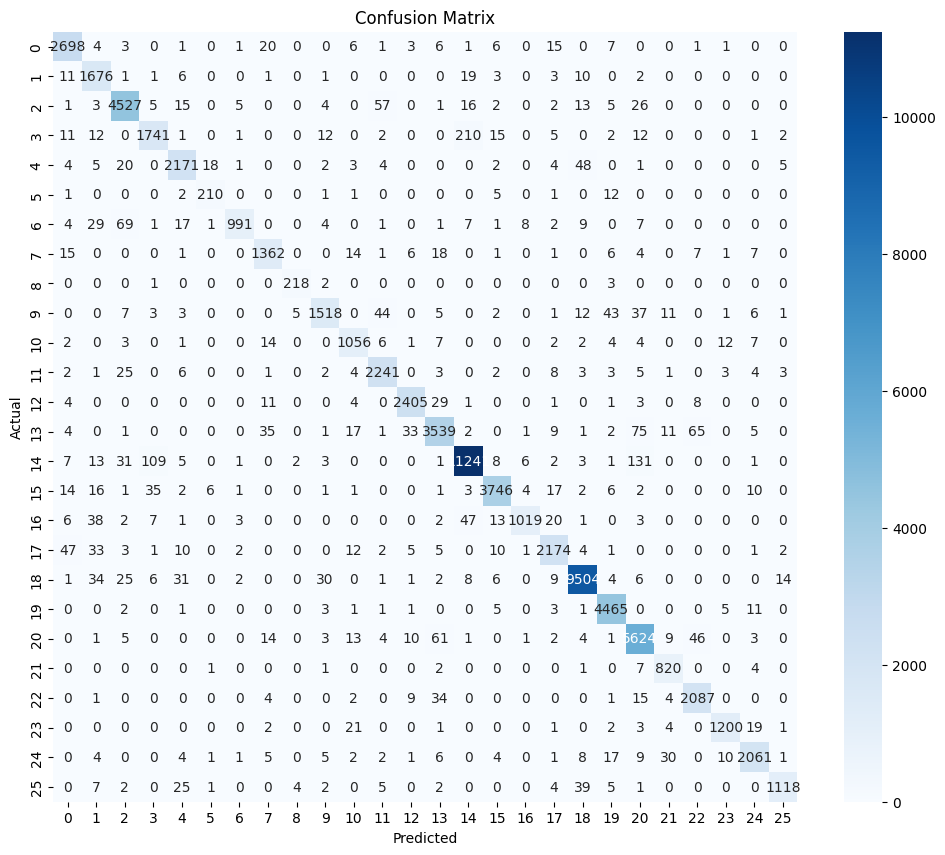

In [157]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**4- ROC & AUC for multi-class**


In [160]:
# Convert labels to one-hot
y_test_bin = label_binarize(y_test, classes=range(26))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(26):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

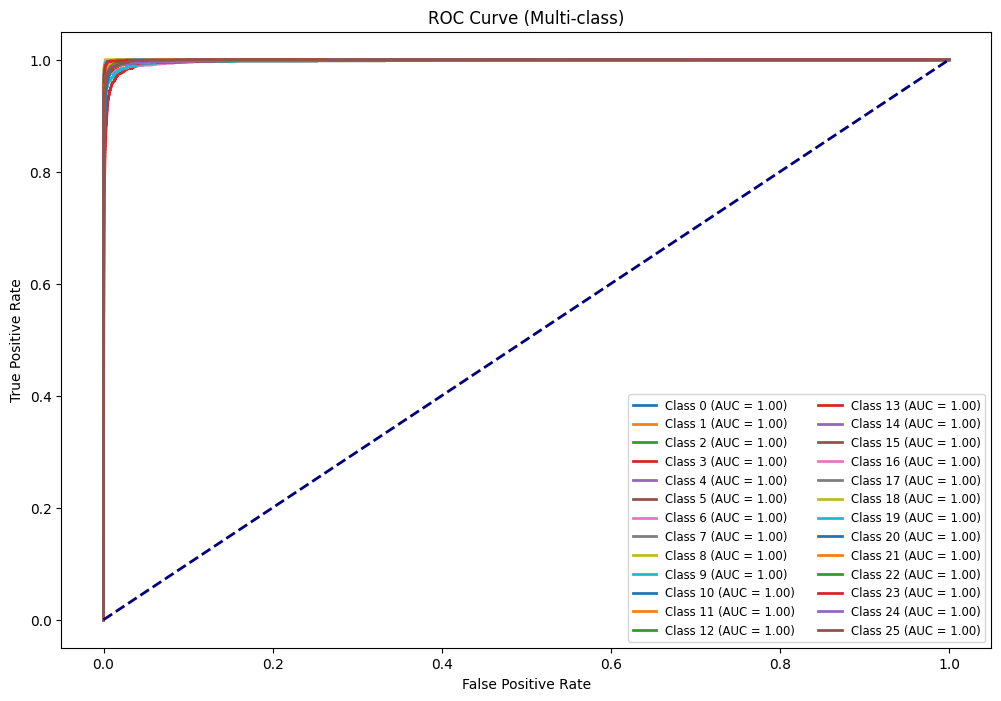

In [161]:
# Plot ROC curve for all classes
plt.figure(figsize=(12,8))
for i in range(26):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multi-class)')
plt.legend(loc='lower right', fontsize='small', ncol=2)
plt.show()